<h1>Synthetic Data Generation

In [7]:
known_turbine_types = np.load("model/turbine_types_order.npy")
known_turbine_types

array(['100', '3.2-103', '3.6-137', '3.8-137', '5M', 'B62/1300',
       'E44/900', 'E70/2300', 'E82/3000', 'E92/2350', 'G114/2500',
       'G80/2000', 'G87/2000', 'G90/2000', 'MM82/2050', 'MM92/2050',
       'N131/3900', 'N149/4.0-4.5', 'N80/2500', 'N90/2500', 'SG 5.0-132',
       'SG 8.0-167 DD', 'SWT-2.3-101', 'SWT-2.3-82', 'SWT-2.3-82 VS',
       'SWT-2.3-93', 'SWT-3.0-101', 'SWT-3.0-113', 'SWT-3.6-107',
       'SWT-3.6-120', 'SWT-6.0-154', 'SWT-7.0-154', 'SWT-DD-130',
       'V112/3000 Offshore', 'V112/3300', 'V112/3450', 'V117/3300',
       'V117/3450', 'V164/8000', 'V164/8400', 'V164/9500', 'V66/1750',
       'V80/2000', 'V90/3000', 'V90/3000 Offshore', 'nan'], dtype='<U32')

In [ ]:
import numpy as np
import pandas as pd
import json

file_path_json = r"C:\Users\alexa\Documents\Webapp\data\power_curves.json"
with open(file_path_json, 'r', encoding='utf-16') as file:
    # Zeilenweise die Inhalte als Python-Listen parsen
    data_raw = [eval(line.strip()) for line in file]
wind_speeds_extracted = [float(item[0]) for item in data_raw]
powers_extracted = [item[1]/1e3 for item in data_raw] # conversion from kW to MW

# assignment of power curve to turbine type
file_path_excel = r"C:\Users\alexa\Documents\Webapp\data\turbine_data.xlsx"
excel_data = pd.read_excel(file_path_excel, sheet_name='Turbine Types')
power_curve_available = excel_data['The Wind Power'].notna()
turbine_types_with_power_curve = np.array(excel_data['Turbine Types'][power_curve_available])

known_turbine_types = np.load("model/turbine_types_order.npy")

# Extraction of the power curves
power_curves_individual = []
j = 0
i = 0
while j < len(wind_speeds_extracted):
    if wind_speeds_extracted[j] == 0:
        power_curves_individual.append([[], []])
        i += 1
    power_curves_individual[i-1][0].append(wind_speeds_extracted[j])
    power_curves_individual[i-1][1].append(powers_extracted[j])
    j += 1

num_real_data_points = 3e6
share_syn_data = 0.1  # 10% der echten Daten
num_synthetic_data = share_syn_data * num_real_data_points
num_per_curve = 10  # 10 Datensätze pro Power Curve
num_power_curves = len(power_curves_individual)
num_synthetic_data_per_dataset = int(num_synthetic_data / num_power_curves / num_per_curve)

# JSON-Datei für synthetische Daten
synthetic_data = []

# Generiere synthetische Daten
for idx, (wind_speeds, powers) in enumerate(power_curves_individual):
    # Prüfen, ob der Turbinentyp bekannt ist
    turbine_type = turbine_types_with_power_curve[idx]
    if turbine_type not in known_turbine_types:
        turbine_type = "nan"

    real_capacity = max(powers)

    for _ in range(num_per_curve):
        # Generiere Windgeschwindigkeiten
        wind_speeds_generated = np.random.uniform(low=min(wind_speeds), high=max(wind_speeds), size=num_synthetic_data_per_dataset)

        # Interpoliere die Leistung basierend auf der Power Curve
        powers_generated = np.interp(wind_speeds_generated, wind_speeds, powers)

        # Generiere zufällige Werte für die anderen Variablen
        capacity = np.random.uniform(0, 15)  # Kapazität zwischen 0 und 15 MW
        hub_height = np.random.uniform(40, 178)  # Nabenhöhe zwischen 40 und 178 m
        year = np.random.randint(1997, 2024)  # Jahr zwischen 1997 und 2023
        month = np.random.randint(1, 13)  # Monat zwischen 1 und 12
        commissioning_date = f"{year}/{month:02d}"

        production_entries = []

        for wind_speed, power_value in zip(wind_speeds_generated, powers_generated):
            production_entries.append([
                "0",  # time not relevant
                round(power_value * capacity / real_capacity, 2),
                round(wind_speed, 2)
            ])

        # Produktionsdatensatz erstellen
        production_entry = {
            "Capacity": round(capacity, 2),
            "Hub_height": round(hub_height, 2),
            "Commissioning_date": commissioning_date,
            "Turbine": turbine_type,
            "Production": production_entries
        }

        synthetic_data.append(production_entry)

unique_turbines = np.unique([entry["Turbine"] for entry in synthetic_data])
print(f"number of unique turbines: {len(unique_turbines)}")

# Speichern der synthetischen Daten in einer JSON-Datei
output_file_path = r"data/synthetic_data.json"
with open(output_file_path, "w", encoding="utf-8") as f:
    json.dump(synthetic_data, f, indent=2, ensure_ascii=False)

print(f"{len(synthetic_data)} synthetische Datensätze wurden in {output_file_path} gespeichert.")

number of unique turbines: 36
360 synthetische Datensätze wurden in data/synthetic_data.json gespeichert.


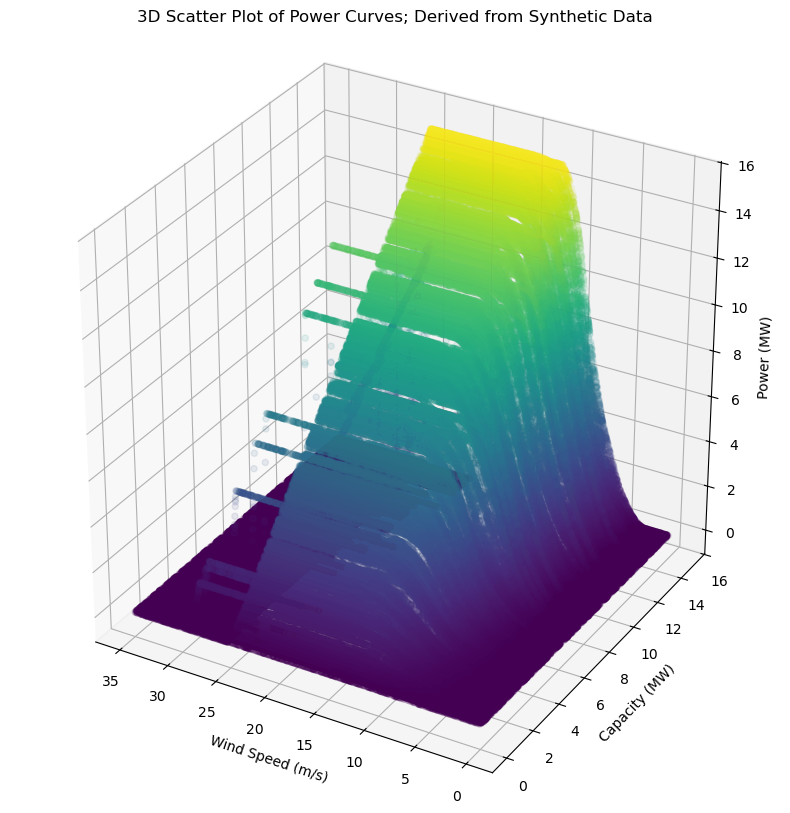

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extrahiere Windgeschwindigkeiten, Kapazitäten und Leistungen
wind_speeds = []
capacities = []
powers = []

for entry in synthetic_data:
    capacity = entry["Capacity"]
    for production_entry in entry["Production"]:
        wind_speed = production_entry[2]
        power = production_entry[1]

        wind_speeds.append(wind_speed)
        capacities.append(capacity)
        powers.append(power)

# Konvertiere zu numpy Arrays
wind_speeds = np.array(wind_speeds)
capacities = np.array(capacities)
powers = np.array(powers)

# Erstelle den 3D-Scatterplot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1, 1, 1])

# Scatterplot
sc = ax.scatter(wind_speeds, capacities, powers, c=powers, cmap="viridis", alpha=0.1)

# Achsen und Titel
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Capacity (MW)")
ax.set_zlabel("Power (MW)")
ax.set_title("3D Scatter Plot of Power Curves; Derived from Synthetic Data")

ax.set_xlim(ax.get_xlim()[::-1])

plt.show()

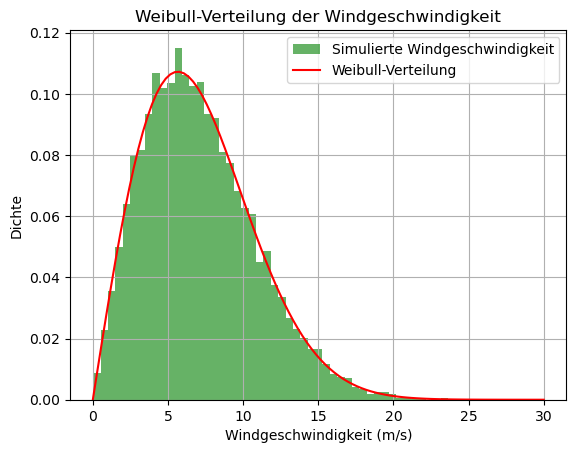

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter der Weibull-Verteilung
k = 2.0  # Formparameter
lambda_ = 8.0  # Skalenparameter

# Simuliere Windgeschwindigkeiten
wind_speeds = np.random.weibull(k, 10000) * lambda_

# Visualisiere die simulierte Verteilung
plt.hist(wind_speeds, bins=50, density=True, alpha=0.6, color='g', label="Simulierte Windgeschwindigkeit")
x = np.linspace(0, 30, 100)
pdf = (k / lambda_) * (x / lambda_)**(k - 1) * np.exp(-(x / lambda_)**k)
plt.plot(x, pdf, 'r-', label="Weibull-Verteilung")
plt.xlabel('Windgeschwindigkeit (m/s)')
plt.ylabel('Dichte')
plt.legend()
plt.grid(True)
plt.title('Weibull-Verteilung der Windgeschwindigkeit')
plt.show()